# Visual monitoring of the anaphase prediction

Here we use the generated measures and predictions of the TTA to generate a video on which the contours of a cell are coloured given the predicted TTA

In [1]:
# %matplotlib inline
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
import seaborn as sns
from skimage import measure # to get contours from masks
import sklearn

import napari

C:\ProgramData\Anaconda3\lib\site-packages\napari\_qt\__init__.py:37: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.9.7. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)


# Load the data

In [7]:
os.chdir("D:/Hugo/Anaphase/Analyse_Descriptive/")

# get images
bf = imageio.volread("Data/BF_f0001-1-100-512x512.tif")
rfp  = imageio.volread("Data/RFP_f0001-1-100.tif")

# get tracks and contours
tracks = pd.read_csv("Data/Tracking_Results_BF_f0001-1-100.1.csv") # tracking positions and the corresponding contours
contours = np.load("Data/Contours_BF_f0001-1-100.npy", allow_pickle=True)

contours32 = []
for c in contours:
    cont = []
    for pos in c:
        cont.append(pos.astype(np.float32))
    contours32.append(np.array(cont))
contours32 = np.array(contours32)
 
tracks["Contours"] = contours32

print(tracks.shape)
tracks.head()

# get predictions
predictions = pd.read_csv("Measures_Predictions_BF_f0001-1-100.csv", sep=";")

print(predictions.shape)
predictions.head()

(22423, 6)
(495, 16)


<ipython-input-7-a82b957a7435>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  contours32 = np.array(contours32)


,Unnamed: 0,idx,frame,time,mom_x,mom_y,daugh_x,daugh_y,mom_surf,daugh_surf,relat_surf,anaphase,anaphase_int,time_to_anaphase,cum_relat_surf,predictions_tta
0,0,0,0,0,463.509804,225.369863,-1.000000,-1.000000,229.730504,0.000000,0.000000,False,0,36,0.000000,36.942691
1,1,0,1,6,463.481911,225.084507,460.542099,238.588235,227.730488,9.534260,0.041866,False,0,30,0.020842,34.165054
2,2,0,2,12,460.345420,225.602740,456.110886,239.965517,229.730504,36.406857,0.158476,False,0,24,0.066853,26.428540
3,3,0,3,18,460.578297,225.698630,455.691877,240.914286,224.730504,51.553944,0.229403,False,0,18,0.106912,21.722870
4,4,0,4,24,461.524165,225.985915,456.054041,241.146341,228.446179,68.701031,0.300732,False,0,12,0.145739,16.990572


In [8]:
# join the predictions to the tracks
count = 0
preds = []
for i, row in tracks.iterrows():
    if not predictions[(predictions["mom_x"] == row["X"]) & (predictions["mom_y"] == row["Y"]) & (predictions["frame"] == row["Frame"])].empty: # retrieve the same mother cell
        preds.append(predictions[(predictions["mom_x"] == row["X"]) & (predictions["mom_y"] == row["Y"]) & (predictions["frame"] == row["Frame"])]["predictions_tta"].values[0])
        count += 1
    elif not predictions[(predictions["daugh_x"] == row["X"]) & (predictions["daugh_y"] == row["Y"]) & (predictions["frame"] == row["Frame"])].empty:  # daughter cell
        preds.append(predictions[(predictions["daugh_x"] == row["X"]) & (predictions["daugh_y"] == row["Y"]) & (predictions["frame"] == row["Frame"])]["predictions_tta"].values[0])
        count += 1
    else:  # if this cell is not in the mother or daughter cells that were measured
        preds.append(-1)

print(f"Number of retrieved cells : {count}")
tracks["predictions_tta"] = preds

tracks.head()

Number of retrieved cells : 787


,Unnamed: 0,ID,Frame,X,Y,Contours,predictions_tta
0,0,36.0,0.0,140.002876,201.506667,"[[149.21568, 205.0], [149.21568, 204.0], [149....",-1.000000
1,1,36.0,1.0,140.314489,201.636364,"[[150.21568, 204.0], [150.21568, 203.0], [150....",-1.000000
2,2,36.0,2.0,136.433110,202.240506,"[[146.21568, 206.0], [146.21568, 205.0], [146....",-1.000000
3,3,36.0,3.0,136.922876,202.680000,"[[146.21568, 207.0], [146.21568, 206.0], [146....",-1.000000
4,4,36.0,4.0,137.885918,203.155844,"[[147.21568, 207.0], [147.21568, 206.0], [147....",36.942691


# Make the visuals

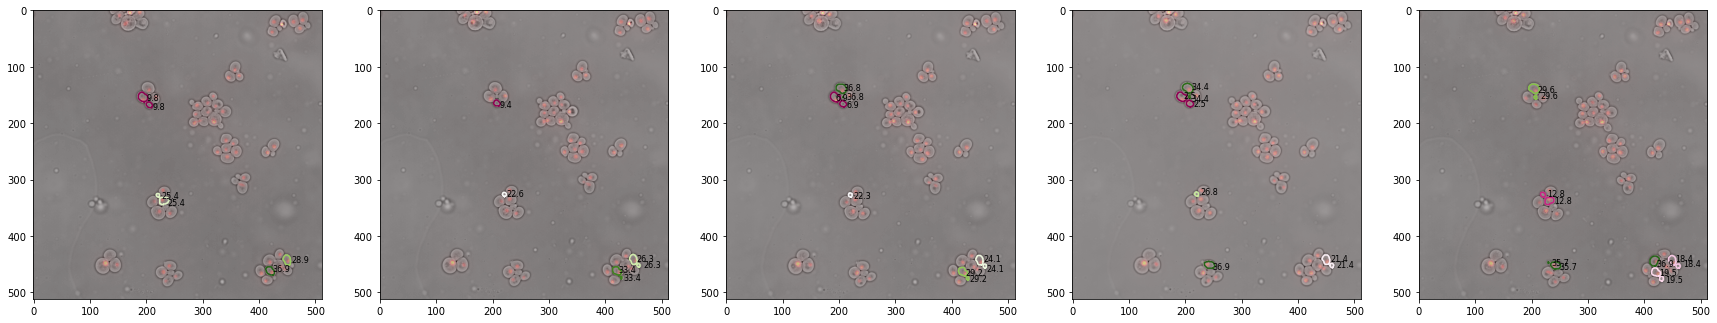

In [107]:
from matplotlib import cm
from matplotlib.colors import Normalize

fmin = 20
frames = 5
norm = Normalize(vmin=10, vmax=35)

def map_colors(tta):
    return cm.PiYG(norm(cell["predictions_tta"]))

fig, ax = plt.subplots(1, frames, figsize=(30, 6))
for frame in range(fmin, fmin + frames):
       
    # images
    ax[frame - fmin].imshow(bf[frame], cmap="Greys")
    ax[frame - fmin].imshow(rfp[frame], cmap="hot", alpha=0.3)
    
    # coloured contours
    subsel = tracks[tracks["Frame"] == frame]
    for i in subsel.index.unique():
        cell = subsel.loc[i]
        if cell["predictions_tta"] >= 0:
            ax[frame - fmin].plot(cell["Contours"][:, 1], cell["Contours"][:, 0], c=map_colors(cell["predictions_tta"]))
            jit_x, jit_y = np.random.normal(5, 2, 1), np.random.normal(5, 2, 1)
            ax[frame - fmin].text(cell["Y"] + jit_x, cell["X"] + jit_y, str(round(cell["predictions_tta"], 1)), fontsize=8)


In [116]:
set_text = []
for frame in range(bf.shape[0]):
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    
    # images
    ax.imshow(bf[frame], cmap="Greys")
    ax.imshow(rfp[frame], cmap="hot", alpha=0.3)
    
    # coloured contours
    subsel = tracks[tracks["Frame"] == frame]
    for i in subsel.index.unique():
        cell = subsel.loc[i]
        if cell["predictions_tta"] >= 0:
            ax.plot(cell["Contours"][:, 1], cell["Contours"][:, 0], c=map_colors(cell["predictions_tta"]), linewidth=3)
            if not cell["predictions_tta"] in set_text:
                jit_x, jit_y = np.random.normal(6, 0.5, 1), np.random.normal(6, 0.5, 1)
                ax.text(cell["Y"] + jit_x, cell["X"] + jit_y, str(round(cell["predictions_tta"], 1)), fontsize=25)
                set_text.append(cell["predictions_tta"])
    ax.axis("off")
    fig.tight_layout()
    plt.savefig(f"Results/BF_f0001_{frame}.png", format="png")
    plt.close()